This analysis examines Coca-Cola’s regional ad spend efficiency using a regression model (XGBoost).
We identify which marketing channels and regions yield the highest ROI.
Results indicate XGBoost achieved strong predictive accuracy (R² > 0.9), with TV and Digital spend as top ROI drivers.

## Context
Coca Cola is a company that sells units globally across 12 regions. Advertisements are used to attract the most buyers: TV ads, Digital Media ads, Outdoor Ads such as billboards, Retail Ads. Ad spending does not always correlate with a return on investment, ROI. As spending on advertising increases, it becomes increaseingly difficult to return a profit. This is why it is essential to use statistical analysis to identify winning strategies to return minimize losses and return the highest ROI as possible.

## Goal
Discover what regions and spending return the highest investment.
Discover what regions and spending return the lowest investment.


In [12]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

# Resolve the absolute path to src folder
src_path = Path('../src').resolve()  # relative from notebook folder
sys.path.append(str(src_path))

# Now you can import train_auc
import synthetic_data_generation , modules

In [13]:
df = synthetic_data_generation.df
df

,region,Year,week,ad_spend_tv,ad_spend_digital,ad_spend_outdoor,ad_spend_retail,avg_temp,holiday,pepsi_spend,sales_volume,total_spend,roi,profit
0,Africa,2022,2022-01-03,99.725017,97.628416,52.977602,75.155653,76.673959,0,76.593035,1776.146647,325.486687,5.456895,1776.146647
1,Africa,2022,2022-01-10,205.612727,157.367827,103.596832,142.610589,89.770006,0,252.314274,1887.367219,609.187976,3.098169,1887.367219
2,Africa,2022,2022-01-17,269.127470,219.780129,142.752905,172.630172,64.875327,0,309.146177,1811.177434,804.290677,2.251894,1811.177434
3,Africa,2022,2022-01-24,89.138581,111.978276,42.709169,94.335479,83.363892,1,102.044273,2077.778008,338.161504,6.144336,2077.778008
4,Africa,2022,2022-01-31,111.066392,140.509752,41.134944,98.118299,61.288528,1,115.743138,2072.609964,390.829386,5.303107,2072.609964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,Southwest,2024,2024-12-02,150.980978,170.793969,66.364224,100.568388,56.884509,0,144.130788,1367.291468,488.707558,2.797770,1367.291468
1880,Southwest,2024,2024-12-09,212.640217,191.635670,178.119213,93.351819,71.880734,0,203.576905,1160.981889,675.746919,1.718072,1160.981889
1881,Southwest,2024,2024-12-16,149.368479,176.879999,87.577305,105.073345,61.488195,0,132.966225,1253.903020,518.899128,2.416468,1253.903020
1882,Southwest,2024,2024-12-23,182.344139,169.017032,85.415575,104.838622,76.653345,0,111.876058,1303.046204,541.615368,2.405852,1303.046204


## Feature Engineering

In [14]:
# Total Profits Column: roi * total spend
df['profit'] = df['roi'] * df['total_spend']
df.insert(12,'profit',df.pop('profit'))
df

# Create a Year Column
df['Year'] = pd.to_datetime(df['week'])
df['Year'] = df['Year'].dt.year
df

# Move it to the second column
column_to_move = df.pop('Year')  # Extracts 'col2' and removes it from df
df.insert(1, 'Year', column_to_move) # Inserts 'col2' at index 0
df

,region,Year,week,ad_spend_tv,ad_spend_digital,ad_spend_outdoor,ad_spend_retail,avg_temp,holiday,pepsi_spend,sales_volume,total_spend,profit,roi
0,Africa,2022,2022-01-03,99.725017,97.628416,52.977602,75.155653,76.673959,0,76.593035,1776.146647,325.486687,1776.146647,5.456895
1,Africa,2022,2022-01-10,205.612727,157.367827,103.596832,142.610589,89.770006,0,252.314274,1887.367219,609.187976,1887.367219,3.098169
2,Africa,2022,2022-01-17,269.127470,219.780129,142.752905,172.630172,64.875327,0,309.146177,1811.177434,804.290677,1811.177434,2.251894
3,Africa,2022,2022-01-24,89.138581,111.978276,42.709169,94.335479,83.363892,1,102.044273,2077.778008,338.161504,2077.778008,6.144336
4,Africa,2022,2022-01-31,111.066392,140.509752,41.134944,98.118299,61.288528,1,115.743138,2072.609964,390.829386,2072.609964,5.303107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,Southwest,2024,2024-12-02,150.980978,170.793969,66.364224,100.568388,56.884509,0,144.130788,1367.291468,488.707558,1367.291468,2.797770
1880,Southwest,2024,2024-12-09,212.640217,191.635670,178.119213,93.351819,71.880734,0,203.576905,1160.981889,675.746919,1160.981889,1.718072
1881,Southwest,2024,2024-12-16,149.368479,176.879999,87.577305,105.073345,61.488195,0,132.966225,1253.903020,518.899128,1253.903020,2.416468
1882,Southwest,2024,2024-12-23,182.344139,169.017032,85.415575,104.838622,76.653345,0,111.876058,1303.046204,541.615368,1303.046204,2.405852


## Exploratory Data Analysis

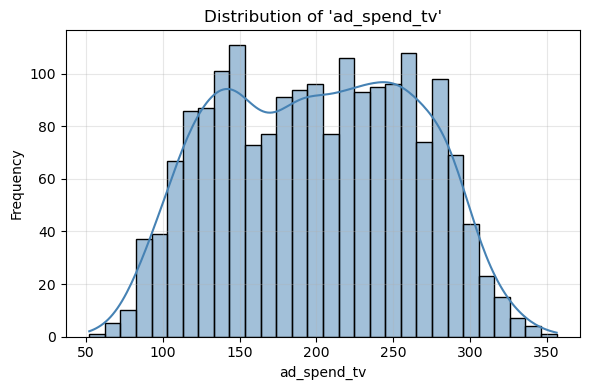

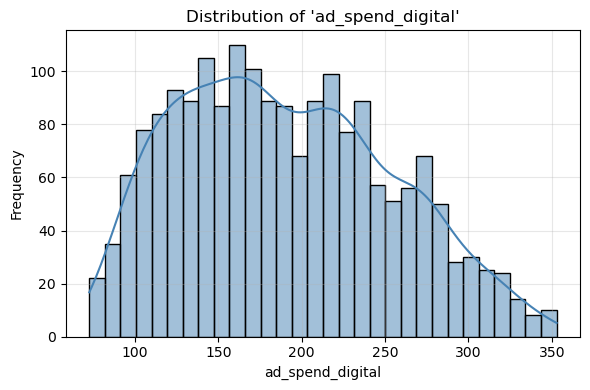

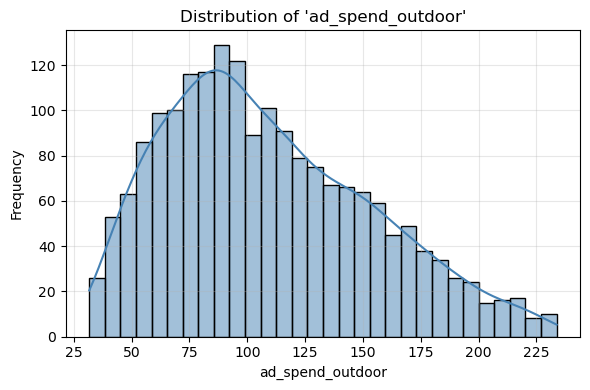

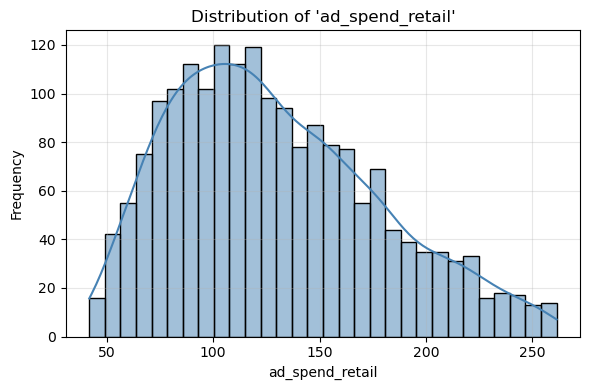

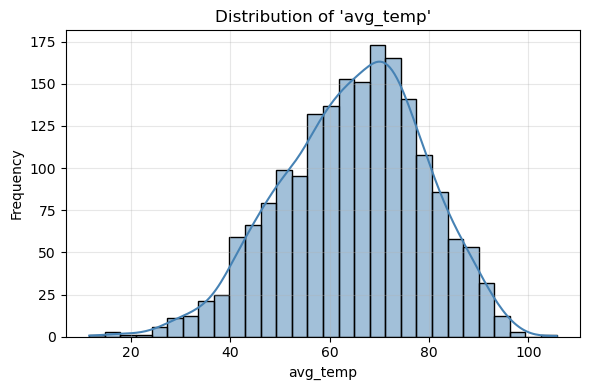

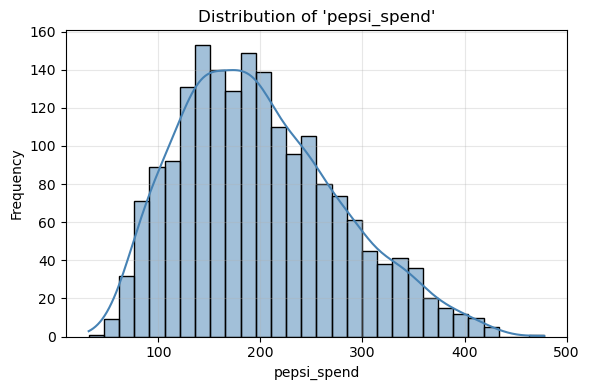

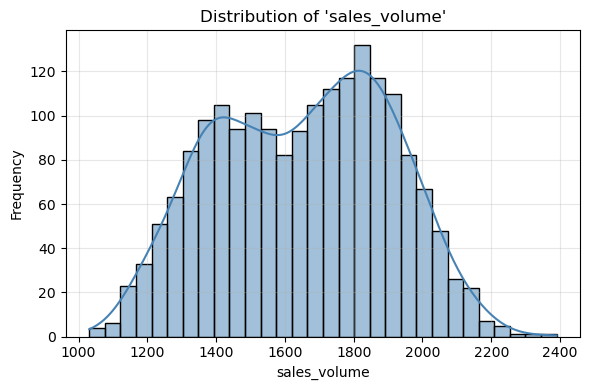

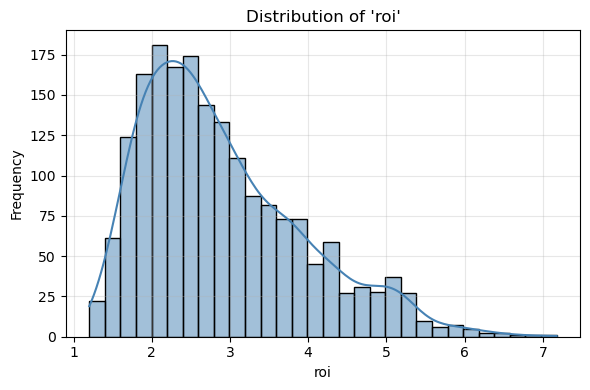


--- Shapiro-Wilk Test Results ---
            Feature  W-Statistic       p-value
4          avg_temp     0.992727  4.876939e-08
6      sales_volume     0.982507  2.035219e-14
0       ad_spend_tv     0.975731  2.435389e-17
1  ad_spend_digital     0.975440  1.882637e-17
5       pepsi_spend     0.973812  4.625486e-18
3   ad_spend_retail     0.966478  1.636375e-20
2  ad_spend_outdoor     0.964999  5.864171e-21
7               roi     0.935333  7.393842e-28


,Feature,W-Statistic,p-value
0,ad_spend_tv,0.975731,2.435389e-17
1,ad_spend_digital,0.975440,1.882637e-17
2,ad_spend_outdoor,0.964999,5.864171e-21
3,ad_spend_retail,0.966478,1.636375e-20
4,avg_temp,0.992727,4.876939e-08
5,pepsi_spend,0.973812,4.625486e-18
6,sales_volume,0.982507,2.035219e-14
7,roi,0.935333,7.393842e-28


In [15]:
import seaborn as sns
from scipy.stats import shapiro

feature_cols = [
    "ad_spend_tv", 
    "ad_spend_digital", 
    "ad_spend_outdoor", 
    "ad_spend_retail", 
    "avg_temp",
    "pepsi_spend", 
    "sales_volume",
    "roi"
]

modules.plot_feature_distributions(df, cols = feature_cols)


Text(0.5, 1.0, 'Coca Cola Advertising Costs')

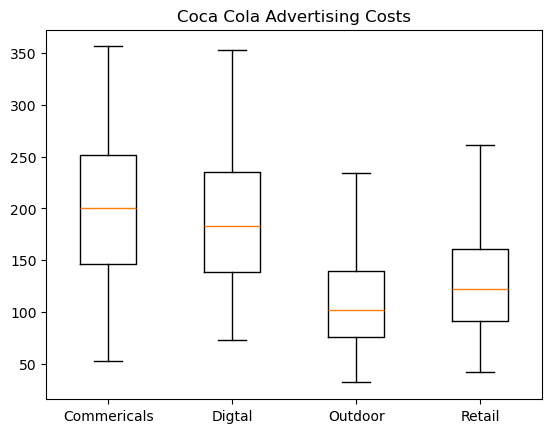

In [16]:
plt.boxplot([df['ad_spend_tv'], df['ad_spend_digital'],df['ad_spend_outdoor'],
                 df['ad_spend_retail']], tick_labels=['Commericals', 'Digtal', 'Outdoor', 'Retail'])
plt.title("Coca Cola Advertising Costs")

Text(0.5, 1.0, 'Regional ROI')

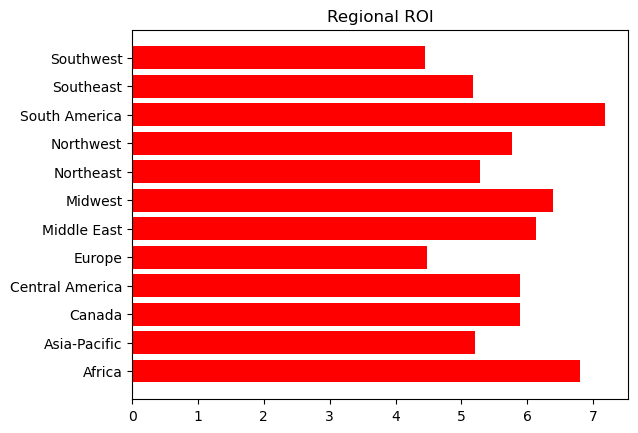

In [17]:
list_regions = df['region']
plt.barh(df['region'], df['roi'],color='red')
plt.title("Regional ROI")

Text(0.5, 1.0, 'Regional sales_volume')

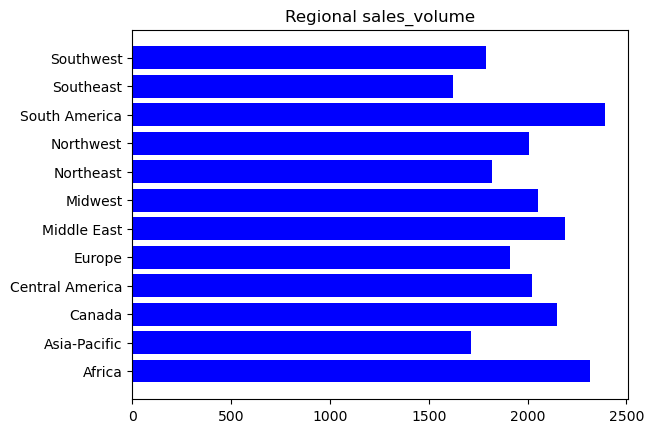

In [18]:
list_regions = df['region']
plt.barh(df['region'], df['sales_volume'], color='blue')
plt.title("Regional sales_volume")

<BarContainer object of 1884 artists>

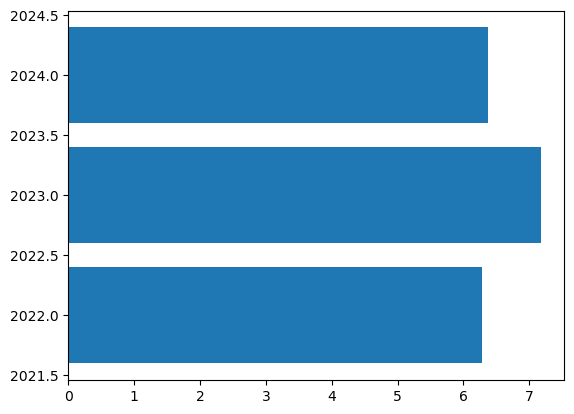

In [19]:
plt.barh(df["Year"],df["roi"])

Text(0.5, 1.0, 'Coca Cola Advertising Costs')

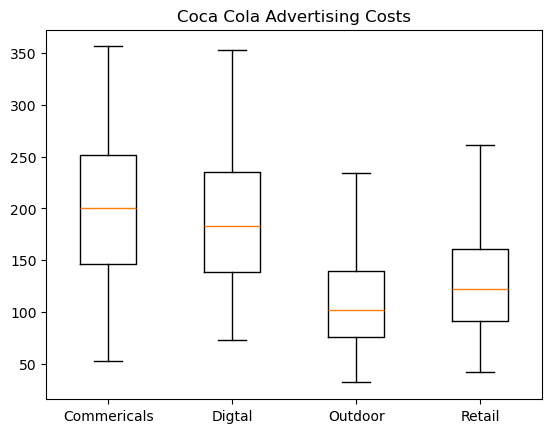

In [20]:
plt.boxplot([df['ad_spend_tv'], df['ad_spend_digital'],df['ad_spend_outdoor'],
                 df['ad_spend_retail']], tick_labels=['Commericals', 'Digtal', 'Outdoor', 'Retail'])
plt.title("Coca Cola Advertising Costs")

The bell curve plots show that most predictors are heavilty skewed to the left or right, with no feature having normal distirbution. As a result, Linear Regression, Logisitic Regression, and PCA cannot be used during analysis. There is also not an issue with the scale of the data, meaning that log transforming will not normalize the data.

In [24]:
spend_cols = [
    "ad_spend_tv", 
    "ad_spend_digital", 
    "ad_spend_outdoor", 
    "ad_spend_retail", 
    "avg_temp",
    "pepsi_spend", 
    "sales_volume",
    "roi"
]  


corr_matrix = df[spend_cols].corr()
corr_matrix

,ad_spend_tv,ad_spend_digital,ad_spend_outdoor,ad_spend_retail,avg_temp,pepsi_spend,sales_volume,roi
ad_spend_tv,1.000000,0.835891,0.704822,0.742422,-0.008864,0.779878,0.135412,-0.823888
ad_spend_digital,0.835891,1.000000,0.658240,0.698419,-0.001685,0.642256,0.163646,-0.774060
ad_spend_outdoor,0.704822,0.658240,1.000000,0.595758,0.009391,0.547218,0.111765,-0.689950
ad_spend_retail,0.742422,0.698419,0.595758,1.000000,0.025478,0.572965,0.145664,-0.709622
avg_temp,-0.008864,-0.001685,0.009391,0.025478,1.000000,-0.020837,0.100968,0.039744
pepsi_spend,0.779878,0.642256,0.547218,0.572965,-0.020837,1.000000,0.080389,-0.646246
sales_volume,0.135412,0.163646,0.111765,0.145664,0.100968,0.080389,1.000000,0.278976
roi,-0.823888,-0.774060,-0.689950,-0.709622,0.039744,-0.646246,0.278976,1.000000


## Evaluating the Correlation Matrix
We are interested in the correlations between roi and the predictor features, as well as sales_volume and the predictor features.

Sales Volume interestingly, does not strongly correlate to any particular ad spending, or comepetitor spending (pepsi_spending). 
In other words, there are no reliable spending habits that directly lead to roi. Instead, there are more complex non-linear relaitonships amongst the variables that lead to an increasing roi.

Return on Investment on the other hand does have many linear relationships, except they're all negative. This can be explained as follows:
ROI is profits/spending. If spending increases, ROI will naturally decrease, and vice versa. Hence the many negative relationships. Naturally it is more likley for ROI to decrease as spending increases, which is what makes effective spending difficult. 

In [35]:
# Make One Hot Encoders for categorical values.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['region_encoded'] = le.fit_transform(df['region'])
df.insert(1,'region_encoded',df.pop('region_encoded'))
df
df['year_encoded'] = le.fit_transform(df['Year'])
df.insert(3,'year_encoded',df.pop('year_encoded'))
df

,region,region_encoded,Year,year_encoded,week,ad_spend_tv,ad_spend_digital,ad_spend_outdoor,ad_spend_retail,avg_temp,holiday,pepsi_spend,sales_volume,total_spend,profit,roi
0,Africa,0,2022,0,2022-01-03,99.725017,97.628416,52.977602,75.155653,76.673959,0,76.593035,1776.146647,325.486687,1776.146647,5.456895
1,Africa,0,2022,0,2022-01-10,205.612727,157.367827,103.596832,142.610589,89.770006,0,252.314274,1887.367219,609.187976,1887.367219,3.098169
2,Africa,0,2022,0,2022-01-17,269.127470,219.780129,142.752905,172.630172,64.875327,0,309.146177,1811.177434,804.290677,1811.177434,2.251894
3,Africa,0,2022,0,2022-01-24,89.138581,111.978276,42.709169,94.335479,83.363892,1,102.044273,2077.778008,338.161504,2077.778008,6.144336
4,Africa,0,2022,0,2022-01-31,111.066392,140.509752,41.134944,98.118299,61.288528,1,115.743138,2072.609964,390.829386,2072.609964,5.303107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,Southwest,11,2024,2,2024-12-02,150.980978,170.793969,66.364224,100.568388,56.884509,0,144.130788,1367.291468,488.707558,1367.291468,2.797770
1880,Southwest,11,2024,2,2024-12-09,212.640217,191.635670,178.119213,93.351819,71.880734,0,203.576905,1160.981889,675.746919,1160.981889,1.718072
1881,Southwest,11,2024,2,2024-12-16,149.368479,176.879999,87.577305,105.073345,61.488195,0,132.966225,1253.903020,518.899128,1253.903020,2.416468
1882,Southwest,11,2024,2,2024-12-23,182.344139,169.017032,85.415575,104.838622,76.653345,0,111.876058,1303.046204,541.615368,1303.046204,2.405852


## Model Development
Our end goal is to create the optimal spending strategey to achieve the highest return of investment -
or in Data Science terms, create a regression model that uses spending features to predict the roi.
After cross-validating and evaluating accuracy metrics, we can use feature importance to decide where to cut or focus spending.

### Selecting XGBoost
I have decided to use XGBoost for the following reasons:
1. The features are not normally distributed and only have negative correlations with roi, therefore Simple Linear Rregressoin requirments are not met.  
2. Ensemble models do not impose a structure to data (like Linear Regression) and can detect more complex, non-linear, relationships. 
3. XGBoost is generally reliable and cost effective ensemble model. 

### XGBoost Hyperparameters
- N_Estimators is set to 500, it's important to have a high number of boosting rounds as boosting algorithms learn more slowly than bagging.
- Max_Deph is set to 5, which is 1 below Pythons default of 6. This was decided to prevent potential overfitting from too much tree depth. Shallow trees are best practice for Boosting Models. They find only the strongest conditions for splits.
- Learning_Rate is set to default 0.05 due to high amount of noise in the data.
- subsample and colsample_bytree are set below default at 0.8 to further prevent overfitting.
- random state is just the seed


In [37]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Select Features and Target
target = df['roi']
predictors = df[['region_encoded','year_encoded','ad_spend_tv','ad_spend_digital','ad_spend_outdoor','ad_spend_retail','avg_temp','holiday','pepsi_spend']]

X = pd.get_dummies(predictors,drop_first=True)
y = target

# 60-40 Train-Test Split
train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=0.4, random_state=42) # 40% test split. random seed 42

# Build Model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(train_X, train_y)
pred = xgb_model.predict(valid_X)

# Generate Evaluation Metrics
MSE = mean_absolute_error(valid_y, pred)
RMSE = mean_squared_error(valid_y, pred)
R2 = r2_score(valid_y, pred) #amongus

print("**EVALUATION METRICS:**")
print(f"MAE: {MSE:.3f} \nRMSE: {RMSE:.3f} \nR2: {R2:.3f}")


**EVALUATION METRICS:**
MAE: 0.179 
RMSE: 0.059 
R2: 0.944


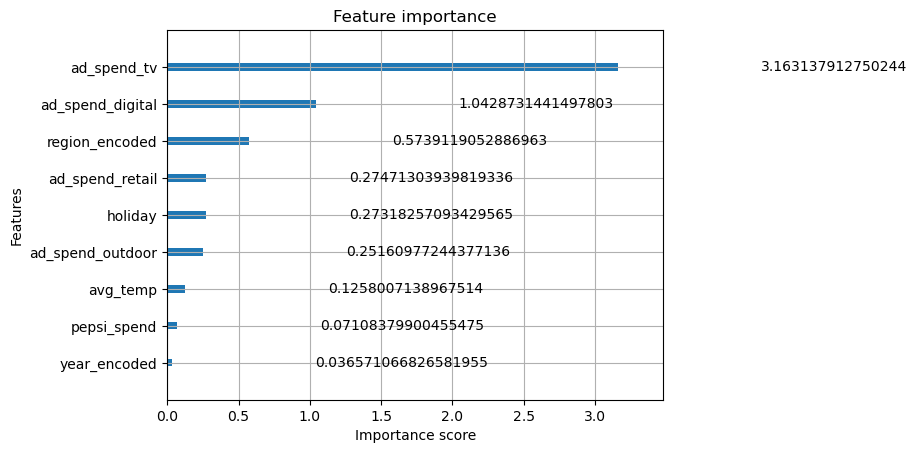

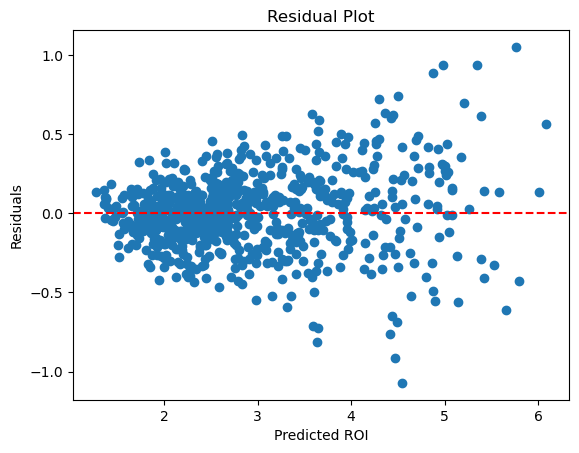

In [38]:
xgb.plot_importance(xgb_model, importance_type='gain')
plt.show()

residuals = valid_y - pred
plt.scatter(pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted ROI")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [39]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1. Make a copy of your current dataset for predictions
X_pred = df.copy()

# 2. Ensure all features used in training exist in the prediction set
predictor_cols = ['region_encoded','year_encoded','ad_spend_tv','ad_spend_digital',
                  'ad_spend_outdoor','ad_spend_retail','avg_temp','holiday','pepsi_spend']

# Fill missing columns with 0 (or some sensible default)
for col in predictor_cols:
    if col not in X_pred.columns:
        X_pred[col] = 0

# 3. Apply same one-hot encoding as during training
X_pred_encoded = pd.get_dummies(X_pred[predictor_cols], drop_first=True)

# 4. Align columns to match training set (in case one-hot encoding created different columns)
X_pred_encoded = X_pred_encoded.reindex(columns=X.columns, fill_value=0)

# 5. Predict ROI
X_pred['PredictedROI'] = xgb_model.predict(X_pred_encoded)

# 6. Sort by highest predicted ROI
X_pred_sorted = X_pred.sort_values('PredictedROI', ascending=False)

# 7. Get top 3 predicted ROI rows per region
topn_per_region = X_pred_sorted.groupby('region_encoded').apply(lambda x: x.nlargest(1, 'PredictedROI')).reset_index(drop=True)

# 8. Map region_encoded back to region names
region_mapping = df[['region', 'region_encoded']].drop_duplicates().set_index('region_encoded')['region'].to_dict()
topn_per_region['region'] = topn_per_region['region_encoded'].map(region_mapping)

# 9. Select relevant columns
topn_per_region = topn_per_region[['region','ad_spend_tv','ad_spend_digital',
                                   'ad_spend_outdoor','ad_spend_retail','PredictedROI']]

# 10. Display the result
topn_per_region


,region,ad_spend_tv,ad_spend_digital,ad_spend_outdoor,ad_spend_retail,PredictedROI
0,Africa,89.138581,111.978276,42.709169,94.335479,6.113261
1,Asia-Pacific,95.474397,95.115822,38.105977,63.825175,5.228184
2,Canada,127.783569,73.822968,48.334797,46.324052,5.867177
3,Central America,93.088659,117.383742,35.452763,94.515234,5.476462
4,Europe,78.574168,81.149284,62.968409,66.358836,4.638795
5,Middle East,85.288442,92.669142,63.615712,51.379769,6.009622
6,Midwest,108.308688,75.786383,37.863068,63.401269,6.323939
7,Northeast,105.858491,97.919938,37.508539,81.962868,5.186187
8,Northwest,98.271672,107.147034,48.532669,85.888858,5.034661
9,South America,92.416294,87.148859,35.757427,52.251913,7.148153


## Buisness Decisions

This last dataframe shows our action plan for each region. The rows above display a weeks worth of spending in each advertising sector. 
The Predicted ROI is predicted by our XGBoost model. 
The dataframe displays the 3 highest accuracy predictor values for each spending sector for each region. 
For example, the ideal South America spendings per week should be:
TV:92.416294 	Digital:87.148859 	Outdoor:35.757427 	Retail:52.251913 	
This is estimated to return an ROI of 7.13.
